# 3. Expérimentation et comparaison des architectures RNN

### Introduction

Ce notebook a pour objectif de **définir les fonctions nécessaires à l’entraînement des modèles**, ainsi que de **sauvegarder automatiquement les résultats** :

- Les **graphiques** générés seront enregistrés dans le dossier `/figures`
- Les **tableaux de résultats** seront enregistrés dans le dossier `/results`

En fin de notebook, un **bloc principal** exécutera les différentes fonctions avec les **paramètres choisis**, afin de lancer les entraînements.

L’objectif est de pouvoir tester facilement **plusieurs configurations de modèles** et d’enregistrer **systématiquement les résultats** pour une analyse future.

L’analyse détaillée des performances sera effectuée dans le dernier notebook : [Analyse des résultats](./04_evaluation_et_analyse.ipynb)


### Import des bibliothèques

In [184]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

Sequential = tf.keras.models.Sequential
SimpleRNN = tf.keras.layers.SimpleRNN
LSTM = tf.keras.layers.LSTM
GRU = tf.keras.layers.GRU
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
Bidirectional = tf.keras.layers.Bidirectional
EarlyStopping = tf.keras.callbacks.EarlyStopping
Adam = tf.keras.optimizers.Adam
Input = tf.keras.Input


### Fonction de chargement des datasets de train, validation et test

In [185]:
def load_dataset(path,ajouter_bruit=False, sigma=0.05):
    df = pd.read_csv(path, header=None)
    data = df.values
    X = data[:, :-1]
    y = data[:, -1]

    X = X[..., np.newaxis]  # forme (samples, window, 1)

    if ajouter_bruit:
        bruit = np.random.normal(0, sigma, size=X.shape)
        X += bruit

    return X, y

X_train, y_train = load_dataset("../data/TrainDataSet.csv", ajouter_bruit=AJOUTER_BRUIT, sigma=BRUIT_SIGMA)
X_val, y_val = load_dataset("../data/ValidationDataSet.csv")
X_test, y_test = load_dataset("../data/TestDataSet.csv")

### Initialisation de la taille de fenêtre constante

In [186]:
WINDOW_SIZE = 14

### Définition des paramètres qui seront utilisés pour l'entraînement

In [187]:
UNITS = None
DROPOUT = None
STACKED = None
USE_BIDIRECTIONAL = None
AJOUTER_BRUIT = None
BRUIT_SIGMA = None        

### Sauvegarde des différents résultats

#### Récuperer les paramètres pour dinstinguer les images et tableaux

In [188]:
def get_param_suffix():
    return (
        f"WS{WINDOW_SIZE}"
        f"_U{UNITS}"
        f"_DO{int(DROPOUT * 100)}"
        f"_{'STACKED' if STACKED else 'SINGLE'}"
        f"_{'BIDIR' if USE_BIDIRECTIONAL else 'UNIDIR'}"
    )

#### Enregistrement des images

In [189]:
def titre_to_filename(titre, dossier="figures", suffix=""):
    if suffix:
        titre += f"__{suffix}"

    nom_fichier = titre + ".png"

    racine_projet = os.path.abspath(os.path.join(os.getcwd(), ".."))
    chemin_figures = os.path.join(racine_projet, dossier)
    os.makedirs(chemin_figures, exist_ok=True)

    return os.path.join(chemin_figures, nom_fichier)

#### Enregistrement des tableaux

In [190]:
def enregistrer_dataframe(df, base_filename="comparaison_performances", dossier="results"):
    suffix = get_param_suffix()
    nom_fichier = f"{base_filename}_{suffix}.csv"

    # Crée le dossier dans la racine du projet
    racine_projet = os.path.abspath(os.path.join(os.getcwd(), ".."))
    chemin_dossier = os.path.join(racine_projet, dossier)
    os.makedirs(chemin_dossier, exist_ok=True)

    chemin_complet = os.path.join(chemin_dossier, nom_fichier)
    df.to_csv(chemin_complet, index=False)

### Construction du modèle

In [191]:
def build_model(rnn_type="SimpleRNN"):
    model = Sequential()
    rnn_layer = None
    model.add(Input(shape=(WINDOW_SIZE, 1)))


    return_sequences = STACKED

    # Création de la couche RNN
    if rnn_type == "SimpleRNN":
        rnn_layer = SimpleRNN(UNITS, return_sequences=return_sequences)
    elif rnn_type == "LSTM":
        rnn_layer = LSTM(UNITS, return_sequences=return_sequences)
    elif rnn_type == "GRU":
        rnn_layer = GRU(UNITS, return_sequences=return_sequences)

    # Bidirectionnal
    if USE_BIDIRECTIONAL:
        model.add(Bidirectional(rnn_layer))
    else:
        model.add(rnn_layer)

    # Deuxième couche RNN si empilement activé
    if STACKED:
        if rnn_type == "SimpleRNN":
            model.add(SimpleRNN(UNITS))
        elif rnn_type == "LSTM":
            model.add(LSTM(UNITS))
        elif rnn_type == "GRU":
            model.add(GRU(UNITS))

    # Couche de sortie
    model.add(Dropout(DROPOUT))
    model.add(Dense(1))  # Sortie de régression

    return model


### Compilation et Entraînement

In [192]:
def compile_and_train(model, X_train, y_train, X_val, y_val):
    model.compile(loss='mse', optimizer=Adam(), metrics=['mae'])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=500,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Affichage de la courbe d'apprentissage
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Courbe de perte - {model.name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    suffix = get_param_suffix()
    filename = titre_to_filename(f"Courbe_de_perte_{model.name}", dossier="figures", suffix=suffix)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    return model

### Évaluation du modèle

In [193]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Visualisation des prédictions
    plt.figure(figsize=(10, 4))
    plt.plot(y_test, label='Réel')
    plt.plot(y_pred, label='Prédit')
    plt.title(f"Réel vs Prédit - {name}")
    plt.legend()
    plt.grid(True)
    suffix = get_param_suffix()
    filename = titre_to_filename(f"Reel_vs_Predit_{name}", dossier="figures", suffix=suffix)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    return {"Modèle": name, "MSE": mse, "MAE": mae, "RMSE": rmse}

### Boucle principale d'expérimentation

In [194]:
def train_and_evaluate_all_models():
    results = []
    trained_models = {}

    for rnn_type in ["SimpleRNN", "LSTM", "GRU"]:
        print(f"\n===== Entraînement du modèle : {rnn_type} =====")
        model = build_model(rnn_type)
        model.name = rnn_type
        model = compile_and_train(model, X_train, y_train, X_val, y_val)

        metrics = evaluate_model(model, X_test, y_test, rnn_type)
        results.append(metrics)
        trained_models[rnn_type] = model

    return results, trained_models



### Tableau comparatif final

In [195]:
def afficher_comparaison_des_performances(results):
    results_df = pd.DataFrame(results)
    print("\nComparaison des performances :")
    print(results_df)
    
    enregistrer_dataframe(results_df)


### Visualisation comparaison des prédictions

In [196]:
def afficher_predictions_detaillees(trained_models,N=100):
    plt.figure(figsize=(14, 6))
    plt.plot(y_test[:N], label="Valeurs réelles", linewidth=2)

    for name, model in trained_models.items():
        y_pred = model.predict(X_test)
        plt.plot(y_pred[:N], label=f"Prédictions {name}")

    titre = "Comparaison des prédictions vs réel (extrait)"
    plt.title(titre)
    plt.xlabel("Temps")
    plt.ylabel("Température (normalisée)")
    plt.legend()
    plt.grid(True)

    suffix = get_param_suffix()
    filename = titre_to_filename(titre, dossier="figures", suffix=suffix)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()



### Experimentation avec les paramètres modifiable

C’est ici que nous allons entraîner nos modèles en faisant varier les différents paramètres.
Les graphiques et tableaux seront affichés dans la sortie (output), mais, comme expliqué précédemment, ils seront également enregistrés pour une analyse future.


===== Entraînement du modèle : SimpleRNN =====


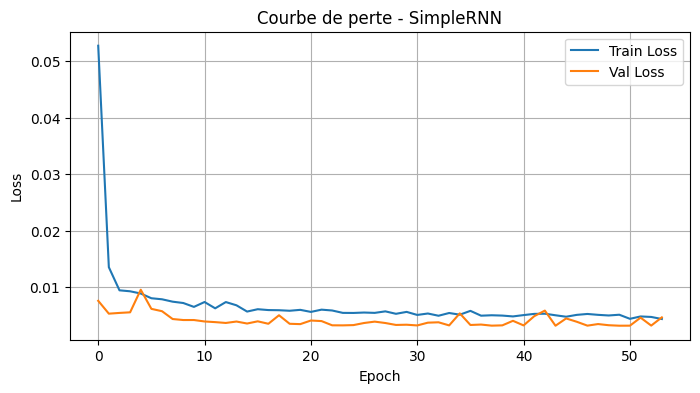

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
SimpleRNN - MSE: 0.0026, MAE: 0.0401, RMSE: 0.0507


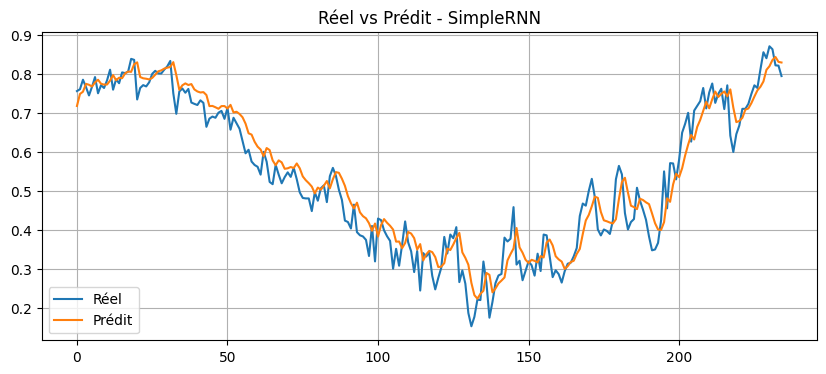


===== Entraînement du modèle : LSTM =====


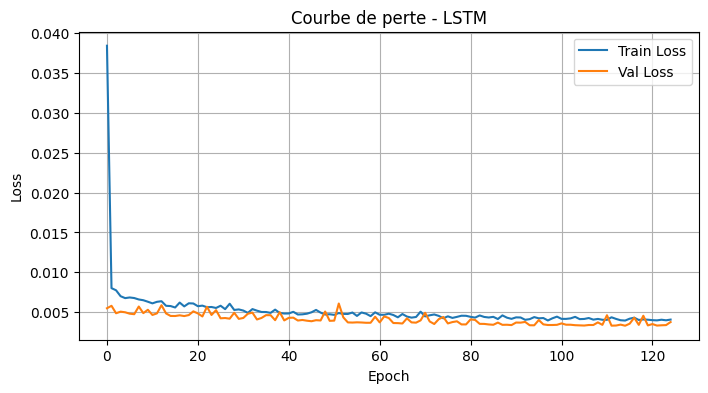

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
LSTM - MSE: 0.0025, MAE: 0.0399, RMSE: 0.0502


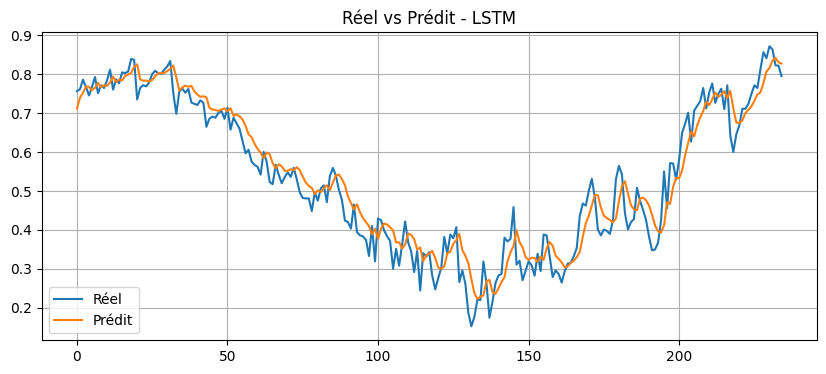


===== Entraînement du modèle : GRU =====


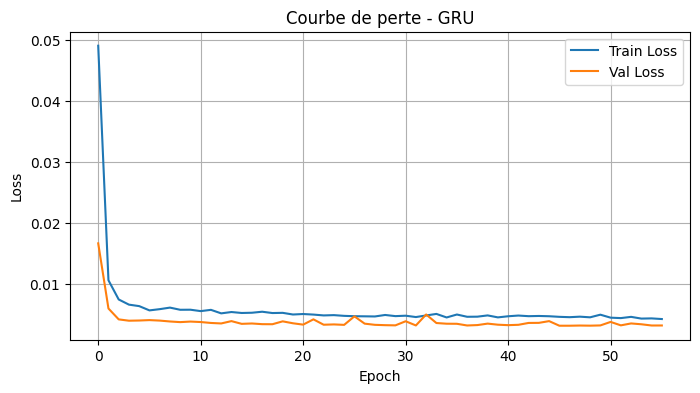

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
GRU - MSE: 0.0025, MAE: 0.0394, RMSE: 0.0497


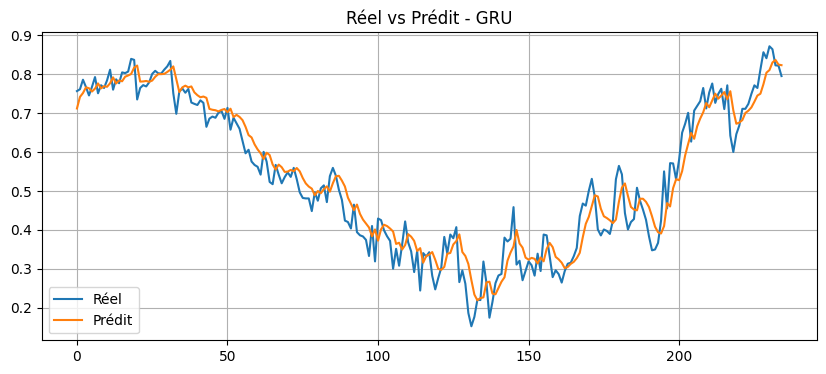

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


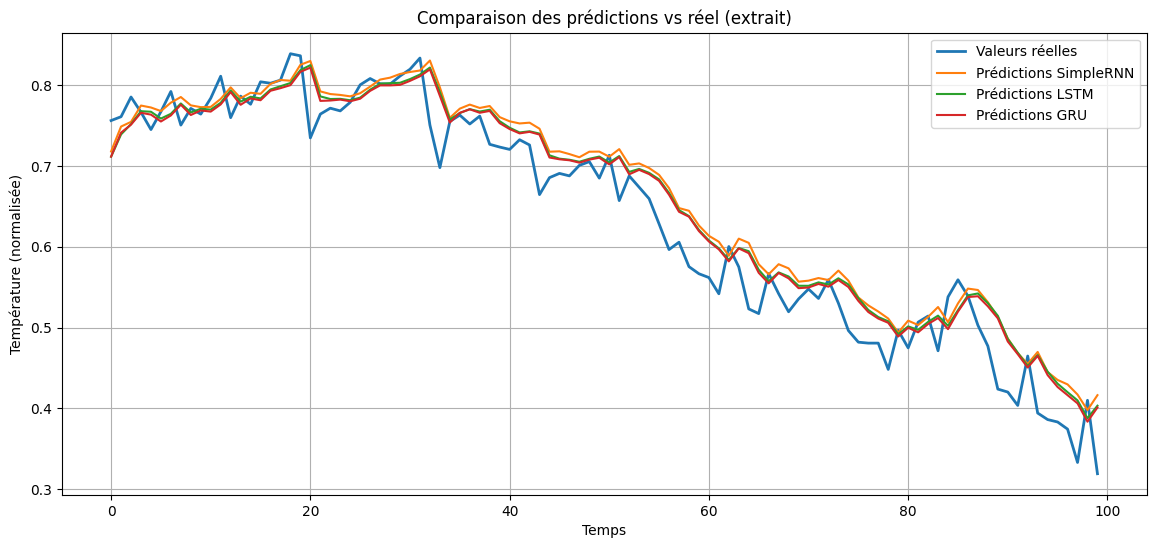


Comparaison des performances :
      Modèle       MSE       MAE      RMSE
0  SimpleRNN  0.002570  0.040122  0.050700
1       LSTM  0.002525  0.039867  0.050247
2        GRU  0.002472  0.039431  0.049718


In [197]:
UNITS = 64
DROPOUT = 0.2
STACKED = False
USE_BIDIRECTIONAL = False
AJOUTER_BRUIT = True
BRUIT_SIGMA = 0.05


results, trained_models = train_and_evaluate_all_models()

afficher_predictions_detaillees(trained_models=trained_models)

afficher_comparaison_des_performances(results)


**Dernier notebook : Entrainement et compilation du modèle**

👉 [Aller au dernier Notebook](./04_evaluation_et_analyse.ipynb)